# Libraries

In [2]:
import os

import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader 

from torchvision import datasets, transforms
from torchvision.io import read_image
import torchvision.utils as vutils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from PIL import Image 
import imageio
from einops import rearrange 
from tqdm import tqdm 

import wandb

%matplotlib inline

In [3]:
print("CUDA available:", torch.cuda.is_available())
print("torch version:", torch.__version__)


CUDA available: False
torch version: 2.6.0


# Weights and Bias' login 
### Track training and evaluation progress of the model 

In [39]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/ray/.netrc
wandb: Currently logged in as: ray-s (ray-s-university-of-alberta) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# CVAE Model

### Creating the CVAE model.


In [37]:
#######################################################
# CVAE IMPLEMENTATION 
#######################################################

class CVAE(nn.Module): 
    def __init__(self, input_channel= 3, c1=32, c2=64, latent_dim=200): 
        super().__init__()

        # Encoder Layers: conv1 -> batchNorm1 -> ReLU1 -> conv2 -> batchNorm2 -> ReLU2 -> Flatten -> FC 
        self.c1 = nn.Conv2d(input_channel, c1, bias=False, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(c1)
        self.r1 = nn.LeakyReLU(0.2)
        self.c2 = nn.Conv2d(c1, c2, bias=False, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(c2)
        self.r2 = nn.LeakyReLU(0.2)
        self.flat = nn.Flatten(start_dim=1) # flatten everything (including color channels)
        
        dummy_input = torch.zeros([1, 3, 218, 178]) # celeba picture size
        dummy_output = self.__get_encoder_output_shape(dummy_input)
        self.fc11 = nn.Linear(dummy_output.shape[1], latent_dim) # gets the mean 
        self.fc12 = nn.Linear(dummy_output.shape[1], latent_dim) # gets the logvar

        # Decoder Layers: FC -> unflatten -> convTranspose -> batchNorm -> ReLU -> output
        self.fc2 = nn.Linear(latent_dim, 256 * 8 * 8)  # 512 channels, 4x4 small feature map
        self.unflatten = nn.Unflatten(1, (256, 8, 8))
        
        self.ct1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)  # 16x16 
        self.bn3 = nn.BatchNorm2d(128)
        self.r3 = nn.LeakyReLU(0.2)     
        
        self.ct2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)   # 32x32 
        self.bn4 = nn.BatchNorm2d(64)
        self.r4 = nn.LeakyReLU(0.2)   

        self.ct3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)    # 64x64 
        self.bn5 = nn.BatchNorm2d(32)
        self.r5 = nn.LeakyReLU(0.2)    

        self.ct4 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)    # 128x128 
        self.bn6 = nn.BatchNorm2d(16)
        self.r6 = nn.LeakyReLU(0.2)   

        self.ct5 = nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1) #256 x 256
        self.sigmoid = nn.Sigmoid()


    def __get_encoder_output_shape(self, x):
        """
        Runs a forward pass on the encoder portion so I can get the shape for nn.Linear
        """
        x = self.c1(x)
        x = self.bn1(x)
        x = self.r1(x) 
        x = self.c2(x)
        x = self.bn2(x)
        x = self.r1(x)
        x = self.flat(x) 
        return x
       
    def encode(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        '''
        The encoder portion of the CVAE. 

        Args: 
            x (Tensor): Input data of shape [batch_size, 178 x 218], flattened images.

        Returns:
            Tuple[Tensor, Tensor]: The mean and log-variance of the approximate posterior 
            distribution q(z|x), where z is the latent variable. 
        '''        
        x = self.r1(self.bn1(self.c1(x)))
        x = self.r2(self.bn2(self.c2(x)))
        x = self.flat(x) 

        mu = self.fc11(x)
        raw_logvar = self.fc12(x)
        logvar = F.softplus(raw_logvar, 1, 10)
        return mu, logvar

    def reparametrize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        '''
        Reparametrization trick standard in CVAE's. 

        Args: 
            mu: The mean of the approximate posterior distribution: q(z|x)
            logvar: The log-variance of the approximate posterior distribution: q(z|x)
        
        Returns: 
            z: The latent variable sampled from q(z|x) using the reparametrization trick.
            z is size [batch_size, latent_dim], in this case, latent_dim=100.
        ''' 
        
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)

        z = mu + std * eps 
        return z 

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        '''
        The decoder portion of CVAE. 
        Args: 
            z: The latent variable. 

        Returns: 
            x_recon: The reconstructed x sampled from the learned distribution of the decoder. 
            In this case, x_recon is a reconstructred picture. 
        '''
        z = self.fc2(z)
        z = self.unflatten(z)
        
        z = self.r3(self.bn3(self.ct1(z)))
        z = self.r4(self.bn4(self.ct2(z)))
        z = self.r5(self.bn5(self.ct3(z)))
        z = self.r6(self.bn6(self.ct4(z)))

        z = z[:, :, 19:19+218, 39:39+178] # crop to get to 218x178

        x_recon = self.sigmoid(self.ct5(z))
        return x_recon
    
    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]: 
        """
        The forward pass on the CVAE. 
        """

        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        print("z mean:", z.mean().item(), "std:", z.std().item())
        x_recon = self.decode(z)
        
        return x_recon, mu, logvar

In [6]:
"""
CVAE TESTING CELL 
"""

# Tensor in (N, C, H, W)
x = torch.zeros([1, 3, 218, 178])   # Test "picture"
#print(test_x)
#print("Shape:", test_x.size())

cvae = CVAE() 
x_recon, _, _ = cvae.forward(x)
print(x_recon.size())


#x_recon = cvae._CVAE__get_encoder_output_shape(x)
#x_recon.size()


torch.Size([1, 3, 218, 178])


# Preprocessing Step
### Preprocess the CelebA labels such that they are a one-hot encoded vector. 

After finishing the prototype, we will put this preprocessing part into a separate file in utils/preprocessing.py

In [7]:
def preprocess_CelebA_labels(input_path:str, output_path:str) -> None: 
    """
    Changes the CelebA labels to a one-hot encoding instead of using 1 and -1. 

    Args: 
        input_path: The labels csv to read in.
        output_path: Create a new csv into this path. 
    """

    label_df = pd.read_csv(input_path)
    label_df.iloc[:, 1:] = (label_df.iloc[:, 1:] + 1)//2 # converts to one-hot 
    label_df.to_csv(output_path, index=False)
    print(f"Processed labels saved into {output_path}.")

In [8]:
# Testing preprocessor  (WORKS!!

input = "../data/CelebA/list_attr_celeba.csv"
output = "../data/CelebA/preprocessed_labels.csv"
#preprocess_CelebA_labels(input, output)

# Dataset Class

### Create a custom dataset class compatible with the torch.DataLoader class
### https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

The custom dataset class needs 3 functions: `__init__`, `__len__`, and `__getitem__`. 

Use an image directory, in my case "data/CelebA/img_align_celeba/. 

Use an annotations file, which is the metadata for the image, or the relevant features for the model to know. 

Notes: 
    - transforms perform manipulation on data to make it suitable for machine learning models to train on.

In [9]:
class CelebAImageDataset(Dataset):
    def __init__(self, img_dir, annotations_file, transform=None, target_transform=None):
        '''
        Args:
            annotations_file: The dataset containing all of the relevant labels. 
            img_dir: The path to the images folder. 
            transform: Modifies the feature data.
            target_transform: Modifies the label data.   
        '''
        
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir 
        self.transform = transform 
        self.target_transform = target_transform 

        #self.img_landmarks = pd.read_csv(landmarks_file) for simplicity, i wont use this yet.

    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx: int) -> tuple[torch.Tensor, pd.Series]: 
        '''
        Retrieves the image and its labels of the corresponding index. 
        '''
        # img_dir in this case is ../data/CelebA/img_align_celeba/img_align_celeba
        # ie. ../data/CelebA/img_align_celeba/img_align_celeba/000001.jpg
        
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]) 
        image = read_image(img_path)
        labels = self.img_labels.iloc[idx, 1:] # retrieves the vector of labels
        labels = torch.tensor(labels) # converts pandas series obj to tensor obj
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            labels = self.target_transform(labels)

        return image, labels 

In [10]:
"""
Testing the dataset class
"""

annotations_file = "../data/CelebA/preprocessed_labels.csv"
img_dir = "../data/CelebA/img_align_celeba/img_align_celeba"

celeba = CelebAImageDataset(img_dir=img_dir, annotations_file=annotations_file)
image, labels = celeba.__getitem__(0) # retrieve image

#display(image)

/var/folders/89/s23t762151989wcy_1bx9vqc0000gn/T/ipykernel_52015/2372924361.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.tensor(labels) # converts pandas series obj to tensor obj


In [11]:
"""
A testing function to display images. 
"""

def display(image: torch.Tensor): 
    if image.dim() == 4: 
        image = image.squeeze(0)
        image_np = image.detach().permute(1, 2, 0).numpy() # convert into numpy array with proper dims
    else: 
        image_np = image.permute(1, 2, 0).numpy() # convert into numpy array with proper dims
    plt.imshow(image_np)
    plt.axis("off")
    plt.show()

# Dataset Manager Class 
### Responsible for partitioning and creating the dataloader. 

In [12]:
from torch.utils.data import Subset

class CelebADatasetManager:
    def __init__(self, img_dir, annotations_file, transform=None, target_transform=None):
        self.dataset = CelebAImageDataset(
            img_dir=img_dir,
            annotations_file=annotations_file,
            transform=transform,
            target_transform=target_transform
        )

        self.split_values = None

    def partition(self, split_value: float):
        """
        Partitions the dataset based on the split_value. ie. 0.6 means 60% train, 40% test.
        Args: 
            split_value: The value that splits the dataset.
        Returns: 
            tuple[torch.Subset, torch.Subset]: Returns the train and test dataset. 
        """
        if split_value >= 1 or split_value <= 0:
            assert False, "split_value must be between (0,1)"
        
        train_split = split_value 
        test_split = 1 - split_value

        train_idx = round(len(self.dataset) * train_split)
        test_idx = round(len(self.dataset) * test_split)

        train_dataset = Subset(self.dataset, np.arange(train_idx))
        test_dataset = Subset(self.dataset, np.arange(test_idx))

        return train_dataset, test_dataset
    

    def get_dataloader(self, split_value: float, batch_size: int = 64, shuffle:bool = True):
        """
        Creates train and test dataloaders. 

        Args: 
            split_value: The value to split the dataset. ie split_value=0.6 corresponds to 60% train and 40% test. 
            batch_size: The batch size when doing SGD.
            shuffle: Shuffles the dataset after every epoch. 
        
        Returns: 
            A tuple containing the train and test dataloaders.
        """
        train_dataset, test_dataset = self.partition(split_value)
        
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle= shuffle)
        
        return train_dataloader, test_dataloader




In [13]:
"""
Testing the dataset manager class.
"""

annotations_file = "../data/CelebA/preprocessed_labels.csv"
img_dir = "../data/CelebA/img_align_celeba/img_align_celeba"

transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float),  # <-- converts uint8 -> float32 and normalizes 0-255 → 0-1
])

ds_manager = CelebADatasetManager(img_dir=img_dir, annotations_file=annotations_file)

train_ds, _ = ds_manager.partition(0.6)
image, _ = train_ds[0]

train_dl, test_dl = ds_manager.get_dataloader(split_value=0.6)
train_features, train_labels = next(iter(train_dl))

print(train_features.size())
train_labels.size()

print(image.size())




torch.Size([64, 3, 218, 178])
torch.Size([3, 218, 178])


/var/folders/89/s23t762151989wcy_1bx9vqc0000gn/T/ipykernel_52015/2372924361.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.tensor(labels) # converts pandas series obj to tensor obj


/var/folders/89/s23t762151989wcy_1bx9vqc0000gn/T/ipykernel_52015/2372924361.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.tensor(labels) # converts pandas series obj to tensor obj


torch.Size([1, 3, 218, 178])


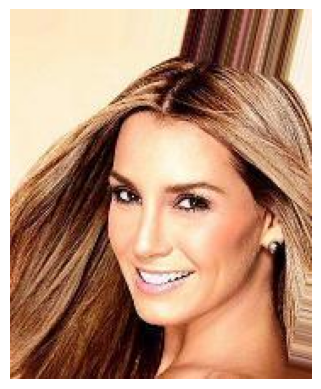

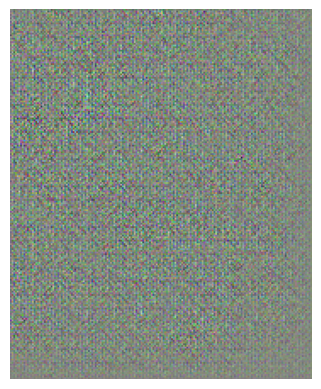

In [14]:
"""
Testing image reconstruction
"""
annotations_file = "../data/CelebA/preprocessed_labels.csv"
img_dir = "../data/CelebA/img_align_celeba/img_align_celeba"

dm = CelebADatasetManager(img_dir=img_dir, annotations_file=annotations_file, transform=transform)
train_ds, _ = dm.partition(0.6)
image, _ = train_ds[0]

cvae = CVAE()

x = image.unsqueeze(0)
print(x.size())

image_recon, _, _ = cvae.forward(x)
display(image)
display(image_recon)

# Loss Function
### Defines a loss function for the CVAE 

In [15]:
def celbo_loss(x_recon, x, mu, logvar, beta:float = 1.0) -> float:
    """
    The ELBO loss used in VAE's / CVAE's.

    Args:
        x_recon: The reconstructed x created from the CVAE 
        x: The original x. 
        mu: The mean of the latent distribution. 
        logvar: The logvariance of the latent distribution.
        beta: The hyperparameter to control how strong the KL loss is. 

    Returns: 
        The total loss (scalar). 
    """

    # computes the kl divergence per sample. 
    # for example, with a batch size of 4, we get: [kl_1, kl_2, kl_3, kl_4]
    kl = -1/2 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1) 
    kl = torch.mean(kl, dim=0) # average over batch size
 
    # take ce loss across samples and get the average across all samples 
    bce = F.binary_cross_entropy(x_recon, x, reduction="mean") 

    elbo_loss = beta * kl + bce
    return elbo_loss
    

# Training the Model
### I'm going to create a Trainer class to organize and create modular code for training.

In [33]:
class Trainer():
    def __init__(self, model, optimizer, train_loader, loss_fn, device = "cpu"):
        """
        Args:
            model: The model architecture the trainer will use. 
            optimizer: The optimizer the trainer will use (adam). 
            train_loader: The training dataset wrapped into the Pytorch DataLoader iterable object. 
            loss_fn: The loss function. 
            epochs: The number of epochs the model will train on.  
            device: The device that PyTorch will run calculations under.
        """
        self.model = model 
        self.optimizer = optimizer 
        self.train_loader = train_loader 
        self.loss_fn = loss_fn 
        self.device = device 
    
    def train(self, epochs=3): 
        """
        Trains the model. 
        """

        wandb.init(
            project="image-generator",
            name="first run"
            config={
                "epochs": epochs, 
                
            }
        )

        self.model.train() # set model to training mode 
        for epoch in range(epochs):
            total_loss= 0
            for batch_x, _ in self.train_loader: 
                self.optimizer.zero_grad() # zero the gradients per batch 
                batch_x.to(self.device)

                batch_x_recon, mu, logvar = self.model.forward(batch_x)

                print("Logvar:", logvar.mean())
                print("Mu:", mu.mean())
                
                loss = celbo_loss(batch_x_recon, batch_x, mu, logvar, beta=0.1)
                print(loss)
                print("------------------------------------ \n")


                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()

            avg_loss = total_loss / len(self.train_loader.dataset)
            print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')


In [38]:
cvae = CVAE()

annotations_file = "../data/CelebA/preprocessed_labels.csv"
img_dir = "../data/CelebA/img_align_celeba/img_align_celeba"

transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float),  # <-- converts uint8 -> float32 and normalizes 0-255 → 0-1
])

ds_manager = CelebADatasetManager(img_dir=img_dir, annotations_file=annotations_file, transform=transform)
train_dl, _ = ds_manager.get_dataloader(0.9)

opt = optim.Adam(cvae.parameters(), lr=1e-3)
trainer = Trainer(model=cvae, optimizer=opt, train_loader=train_dl, loss_fn=celbo_loss)
trainer.train(1)

# FIX PROBLEM WITH EXPLODING GRADIENTS.
'''
1. logvariance explodes 
'''

'''
ATTEMPTS: 
1. reducing starting channels in the decoder from 512 to 256, to lessen the "deepness" 
    of the neural network. (doesn't do anything)
2. using leakyReLU instead of normal ReLU on the encoder portion.
3. using leakyReLU on the decoder portion as well. 
4. lower latent dimension (from 2000 to 200)
5. added a logging line for z in the cvae forward pass method

FROM THESE METHODS, it reaches infinity slower now. 

6. use softplus function to constrain the log variance to always be positive (this seems like the biggest fix)
'''



/var/folders/89/s23t762151989wcy_1bx9vqc0000gn/T/ipykernel_52015/2372924361.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels = torch.tensor(labels) # converts pandas series obj to tensor obj


z mean: -0.01588587276637554 std: 1.4952014684677124
Logvar: tensor(0.7137, grad_fn=<MeanBackward0>)
Mu: tensor(-0.0150, grad_fn=<MeanBackward0>)
tensor(6.2002, grad_fn=<AddBackward0>)
------------------------------------ 

z mean: 2.188307046890259 std: 37.74170684814453
Logvar: tensor(1.5311e-16, grad_fn=<MeanBackward0>)
Mu: tensor(2.1852, grad_fn=<MeanBackward0>)
tensor(14280.2295, grad_fn=<AddBackward0>)
------------------------------------ 

z mean: 0.7782379388809204 std: 11.313302040100098
Logvar: tensor(3.9128e-28, grad_fn=<MeanBackward0>)
Mu: tensor(0.7833, grad_fn=<MeanBackward0>)
tensor(1274.9899, grad_fn=<AddBackward0>)
------------------------------------ 

z mean: -1.7508063316345215 std: 21.84466552734375
Logvar: tensor(2.2070e-39, grad_fn=<MeanBackward0>)
Mu: tensor(-1.7388, grad_fn=<MeanBackward0>)
tensor(4796.0723, grad_fn=<AddBackward0>)
------------------------------------ 

z mean: -1.9247742891311646 std: 23.659273147583008
Logvar: tensor(6.2703e-35, grad_fn=<Mean

KeyboardInterrupt: 